In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd

data_path = '/kaggle/input/digit-recognizer/train.csv'

In [3]:
import pandas as pd
import numpy as np

def load_data(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Extract the pixel data from the DataFrame
    pixel_data = df.values
#     print(pixel_data[0].shape[0]-1)
#     Reshape the pixel data to images
    images = []
    labels = []
    for pixels in pixel_data:
        # Reshape the pixel data to the original image shape (e.g., 224x224x3 for RGB images)
        image = pixels[1:].reshape((28, 28, 1))
        label = pixels[0]
        # Append the image to the list of images
        images.append(image)
        labels.append(label)
    
    return images, labels

In [4]:
images, labels = load_data(data_path)

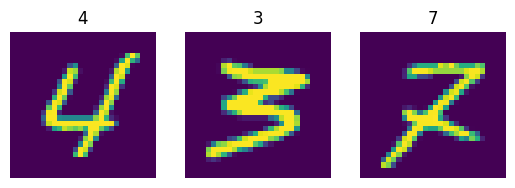

In [5]:
import matplotlib.pyplot as plt

# Define the indices of the images you want to display
indices = [882, 883, 884]

# Create a subplot for each image
for i, idx in enumerate(indices, start=1):
    plt.subplot(1, len(indices), i)
    plt.imshow(images[idx])
    plt.title(labels[idx])  # Add a title to the image
    plt.axis('off')  # Turn off axis

plt.show()

In [6]:
len(images),len(labels)

(42000, 42000)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def augment_images(images, rotation_range=20, width_shift_range=0.1,
                   height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                   horizontal_flip=True, fill_mode='nearest'):
    # Create an ImageDataGenerator object with the specified augmentations
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode=fill_mode
    )

    # Fit the ImageDataGenerator object to your data (optional)
    datagen.fit(images)

    # Generate augmented images
    augmented_images = []
    for img in images:
        augmented_img = next(datagen.flow(np.expand_dims(img, axis=0), batch_size=1))[0]
        augmented_images.append(augmented_img.squeeze())

    return augmented_images

2024-03-12 11:10:56.776049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 11:10:56.776249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 11:10:56.963543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
# Generate augmented images for the first set
augmented_images1 = augment_images(images)

In [9]:
# Generate augmented images for the second set with different parameters
augmented_images2 = augment_images(images, rotation_range=30, width_shift_range=0.2,height_shift_range=0.2, shear_range=0.3, zoom_range=0.3)

In [10]:
# Combine lists into a list of tuples
all_images = images + augmented_images1 + augmented_images2
all_labels = labels*3

In [11]:
import cv2

all_images = [img.reshape(28, 28, 1) for img in all_images]
all_images = np.stack(all_images)
all_labels = np.array(all_labels)

In [12]:
all_images.shape

(126000, 28, 28, 1)

In [13]:
len(all_images),len(all_labels)

(126000, 126000)

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_images(images, labels, num_images=12):
    # Get random indices
    random_indices = np.random.choice(len(images), size=num_images, replace=False)
    # Create subplots
    fig, axes = plt.subplots(3, 4, figsize=(7, 7))

    # Plot each image with its label
    for i, idx in enumerate(random_indices):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        ax.imshow(images[idx])
        ax.set_title(f"Label: {labels[idx]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

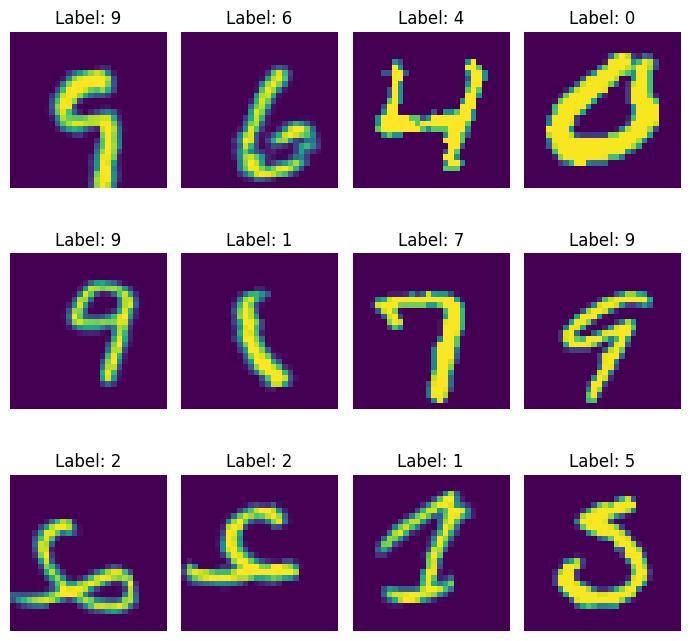

In [15]:
show_random_images(all_images, all_labels)

In [16]:
from sklearn.model_selection import train_test_split

train_images, temp_images , train_labels , temp_labels = train_test_split(all_images, all_labels, test_size=0.4, random_state=42)
val_images, test_images , val_labels , test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=123)

In [17]:
## Model
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.layers import Dense, BatchNormalization

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.55))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Summary about the Model
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,554 (908.41 KB)

 Trainable params: 232,362 (907.66 KB)

 Non-trainable params: 192 (768.00 B)

In [18]:
# Train the model (replace this with your training data and labels)
history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 134s 111ms/step - accuracy: 0.6031 - loss: 1.2706 - val_accuracy: 0.8890 - val_loss: 0.3580
Epoch 2/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 134s 113ms/step - accuracy: 0.8710 - loss: 0.4083 - val_accuracy: 0.9222 - val_loss: 0.2440
Epoch 3/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 137s 109ms/step - accuracy: 0.9058 - loss: 0.3022 - val_accuracy: 0.9429 - val_loss: 0.1832
Epoch 4/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 148s 114ms/step - accuracy: 0.9206 - loss: 0.2559 - val_accuracy: 0.9426 - val_loss: 0.1847
Epoch 5/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 139s 112ms/step - accuracy: 0.9321 - loss: 0.2206 - val_accuracy: 0.9429 - val_loss: 0.1936
Epoch 6/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 133s 112ms/step - accuracy: 0.9380 - loss: 0.1978 - val_accuracy: 0.9573 - val_loss: 0.1466
Epoch 7/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 141s 112ms/step - accuracy: 0.9457 - loss: 0.1748 - val_accuracy: 0.9604 - val_loss: 0.1274
Epoch 8/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 146s 115ms/step - ac

In [19]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

788/788 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9716 - loss: 0.0960
Test Accuracy: 0.973293662071228


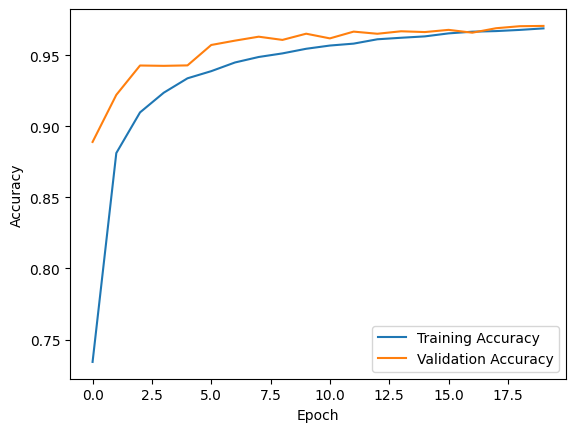

In [20]:
import matplotlib.pyplot as plt

# Plot Accuracy Curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
predictions = model.predict(test_images)
prediction_labels = []

for prediction in predictions:
  prediction_labels.append(np.argmax(prediction))

788/788 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step


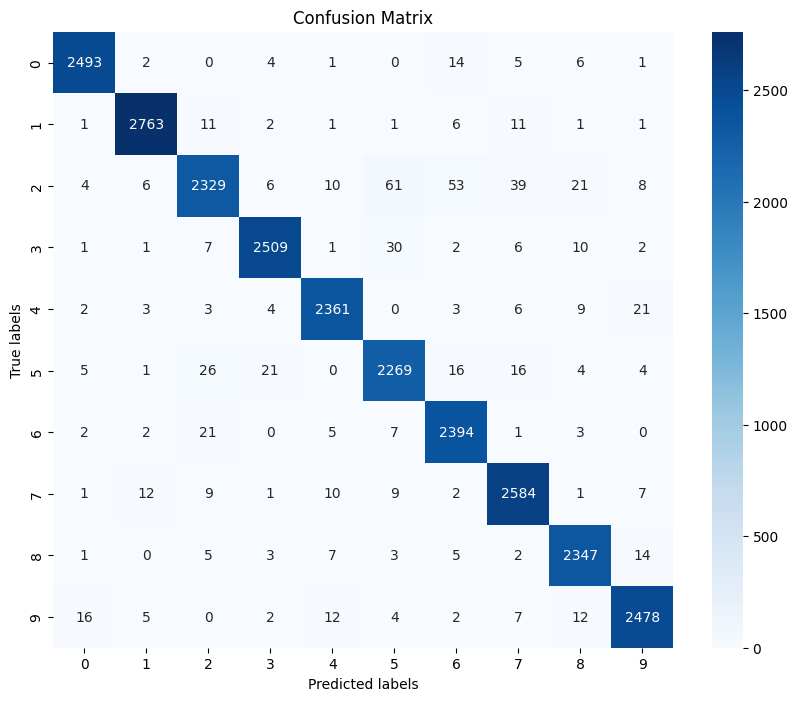

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, prediction_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()